In [1]:
import zipfile, os


In [ ]:
os.makedirs('data', exist_ok=True)
with zipfile.ZipFile('Simpsons.zip') as zf: #if using DRIVE /content/drive/MyDrive/Simpsons.zip
    zf.extractall('data')

In [7]:
from pathlib import Path


root = Path("data/archive/characters_train")

subdirs = [f for f in root.iterdir() if f.is_dir()]
print(f"Total folders: {len(subdirs)}\n")

dict_counts = {}
for path in sorted(subdirs):
    dict_counts[path] = sum(1 for f in path.rglob("*") if f.is_file())
    print(f"{path.name}: {dict_counts[path]}")




Total folders: 42

abraham_grampa_simpson: 731
agnes_skinner: 34
apu_nahasapeemapetilon: 499
barney_gumble: 85
bart_simpson: 1074
carl_carlson: 79
charles_montgomery_burns: 955
chief_wiggum: 789
cletus_spuckler: 38
comic_book_guy: 376
disco_stu: 7
edna_krabappel: 366
fat_tony: 22
gil: 22
groundskeeper_willie: 97
homer_simpson: 1797
kent_brockman: 399
krusty_the_clown: 965
lenny_leonard: 248
lionel_hutz: 3
lisa_simpson: 1084
maggie_simpson: 103
marge_simpson: 1033
martin_prince: 57
mayor_quimby: 197
milhouse_van_houten: 864
miss_hoover: 14
moe_szyslak: 1162
ned_flanders: 1164
nelson_muntz: 287
otto_mann: 26
patty_bouvier: 58
principal_skinner: 956
professor_john_frink: 52
rainier_wolfcastle: 36
ralph_wiggum: 72
selma_bouvier: 83
sideshow_bob: 702
sideshow_mel: 32
snake_jailbird: 44
troy_mcclure: 7
waylon_smithers: 145


In [16]:
import json
from pathlib import Path

def create_qjson_from_dict():
    # convert Path keys to simple strings; use .stem if you want folder names
    class_names = sorted(str(k) for k in dict_counts.keys())

    with open("q.json", "w") as f:
        json.dump(class_names, f, indent=4)

    print(f"✅ Created q.json with {len(class_names)} classes!")
    print("\nClass Index Mapping:")
    print("=" * 60)
    for i, cls in enumerate(class_names):
        display_name = cls.replace("_", " ").title()
        print(f"  Class {i:2d}: {display_name}")
    print("=" * 60)

    with open("q.json", "r") as f:
        loaded = json.load(f)
    print(f"\n✅ Verified: q.json contains {len(loaded)} character names")

    return class_names

# create_qjson_from_dict()


In [17]:
create_qjson_from_dict()

✅ Created q.json with 42 classes!

Class Index Mapping:
  Class  0: Data\Archive\Characters Train\Abraham Grampa Simpson
  Class  1: Data\Archive\Characters Train\Agnes Skinner
  Class  2: Data\Archive\Characters Train\Apu Nahasapeemapetilon
  Class  3: Data\Archive\Characters Train\Barney Gumble
  Class  4: Data\Archive\Characters Train\Bart Simpson
  Class  5: Data\Archive\Characters Train\Carl Carlson
  Class  6: Data\Archive\Characters Train\Charles Montgomery Burns
  Class  7: Data\Archive\Characters Train\Chief Wiggum
  Class  8: Data\Archive\Characters Train\Cletus Spuckler
  Class  9: Data\Archive\Characters Train\Comic Book Guy
  Class 10: Data\Archive\Characters Train\Disco Stu
  Class 11: Data\Archive\Characters Train\Edna Krabappel
  Class 12: Data\Archive\Characters Train\Fat Tony
  Class 13: Data\Archive\Characters Train\Gil
  Class 14: Data\Archive\Characters Train\Groundskeeper Willie
  Class 15: Data\Archive\Characters Train\Homer Simpson
  Class 16: Data\Archive\Chara

['data\\archive\\characters_train\\abraham_grampa_simpson',
 'data\\archive\\characters_train\\agnes_skinner',
 'data\\archive\\characters_train\\apu_nahasapeemapetilon',
 'data\\archive\\characters_train\\barney_gumble',
 'data\\archive\\characters_train\\bart_simpson',
 'data\\archive\\characters_train\\carl_carlson',
 'data\\archive\\characters_train\\charles_montgomery_burns',
 'data\\archive\\characters_train\\chief_wiggum',
 'data\\archive\\characters_train\\cletus_spuckler',
 'data\\archive\\characters_train\\comic_book_guy',
 'data\\archive\\characters_train\\disco_stu',
 'data\\archive\\characters_train\\edna_krabappel',
 'data\\archive\\characters_train\\fat_tony',
 'data\\archive\\characters_train\\gil',
 'data\\archive\\characters_train\\groundskeeper_willie',
 'data\\archive\\characters_train\\homer_simpson',
 'data\\archive\\characters_train\\kent_brockman',
 'data\\archive\\characters_train\\krusty_the_clown',
 'data\\archive\\characters_train\\lenny_leonard',
 'data\\ar

we have the class imbalance


In [5]:
n_images = sum(dict_counts.values())
n_images

16764

to address class imbalance, i use weighted BCE loss. if it doesnt going to work i am going to use the focal loss, lets see



In [30]:
from pathlib import Path
from collections import Counter, defaultdict
from PIL import Image

In [7]:
from pathlib import Path
from collections import Counter, defaultdict
from PIL import Image

root = Path("data/archive/characters_train")
suffixes = {".jpg", ".jpeg", ".png"}
sizes = Counter()
per_dir = defaultdict(Counter)
errors = []

for p in root.rglob("*"):
    if not (p.is_file() and p.suffix.lower() in suffixes):
        continue
    try:
        with Image.open(p) as im:
            size = (im.width, im.height, len(im.getbands()))
        sizes[size] += 1
        per_dir[p.parent.name][size] += 1
    except Exception as e:
        errors.append((p, str(e)))

total_imgs = sum(sizes.values())
print(f"Total images: {total_imgs}")
print(f"Unique sizes: {len(sizes)}\n")

print("Top 10 sizes:")
for (w, h, c), n in sizes.most_common(10):
    print(f"  {w}x{h}x{c}: {n}")

print("\nSizes that occur <= 5 times:")
for (w, h, c), n in sizes.items():
    if n <= 5:
        print(f"  {w}x{h}x{c}: {n}")

if errors:
    print(f"\nErrors on {len(errors)} files; first few:")
    for p, msg in errors[:5]:
        print(f"  {p}: {msg}")


Total images: 16764
Unique sizes: 275

Top 10 sizes:
  320x480x3: 2507
  288x432x3: 2285
  640x480x3: 1707
  576x432x3: 1508
  312x352x3: 1453
  288x416x3: 1306
  576x416x3: 913
  624x352x3: 736
  256x379x3: 507
  320x464x3: 374

Sizes that occur <= 5 times:
  256x661x3: 1
  604x256x3: 2
  256x594x3: 3
  284x256x3: 4
  256x643x3: 1
  256x437x3: 4
  256x297x3: 3
  266x256x3: 2
  256x291x3: 5
  256x256x3: 5
  256x333x3: 3
  256x652x3: 3
  256x463x3: 4
  321x256x3: 1
  256x391x3: 2
  328x256x3: 5
  256x283x3: 4
  320x256x3: 4
  256x381x3: 3
  367x256x3: 1
  256x390x3: 2
  445x256x3: 1
  256x270x3: 4
  256x348x3: 3
  256x280x3: 5
  256x277x3: 4
  256x326x3: 5
  347x256x3: 4
  462x256x3: 1
  256x338x3: 4
  256x279x3: 5
  377x256x3: 3
  449x256x3: 1
  256x373x3: 3
  432x256x3: 2
  256x278x3: 4
  256x282x3: 2
  322x256x3: 5
  256x345x3: 5
  458x256x3: 1
  313x256x3: 5
  291x256x3: 2
  280x256x3: 1
  288x256x3: 2
  256x274x3: 5
  420x256x3: 3
  256x399x3: 5
  263x256x3: 4
  256x260x3: 4
  256x

as we can see the we have the different sizes, according to guidline input images should have the same dimensions, to think how CNN works: it each convolutenial layer applies filters input image,  when the input dimensions differ this means the features maps would have different dimensions, and whenever we are going to move fully connected layer atwe wontt get a same sized input, this is going to cause the shape mismatch error, going to fix that in the dataloader(128x128 would be the sweet spot, not too much not too small dimension), Also pixels wary from 0-255 i am going to scale them also, well one reason is vanishing gradient(but if i am going to use the Resnet that it is really not the case), and as the activation function i am using Relu, $Relu(x) \rightarrow (0,x)$,

Mis-labeled data,clearly not agnes skinner, pic_0015.jpg, in age skinner folder(Matrix is trying to set me up)
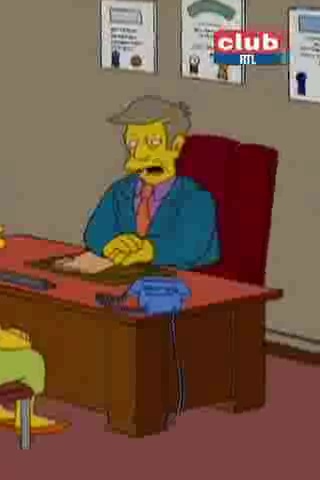


for reproducebility

In [32]:
import os
import random
import numpy as np
import torch

# ---------------------------
# 1. Python built-in RNG seed
# ---------------------------
random.seed(42)

# ---------------------------
# 2. NumPy RNG seed
# ---------------------------
np.random.seed(42)

# ---------------------------
# 3. PyTorch RNG seeds
# ---------------------------
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)  # If you use multi-GPU

# ----------------------------------------------------------
# 4. Make cuDNN deterministic (removes nondeterministic ops)
# ----------------------------------------------------------
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# ----------------------------------------------------------
# 5. Worker-seed fixing for DataLoader (VERY IMPORTANT)
# ----------------------------------------------------------
def seed_worker(worker_id):
    """Ensure each DataLoader worker has consistent reproducible seeds."""
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

# ----------------------------------------------------------
# 6. Create a Generator for DataLoader shuffling
# ----------------------------------------------------------
g = torch.Generator()
g.manual_seed(42)


Creating Loaders for the test and validation set, i would have 64% for training and 16% for validation
for some reason in the clould some of the images got corrupted, that is why i am addign the check 

In [33]:
import os
import random
import numpy as np
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, Subset
from PIL import Image

# ===== SEED EVERYTHING =====
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(42)
# ===========================

class CustomImageFolder(datasets.ImageFolder):
    def find_classes(self, directory):
        classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir() and entry.name != '__MACOSX')
        if not classes:
            raise FileNotFoundError(f"Couldn't find any class folder in {directory}.")
        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        return classes, class_to_idx

def is_valid_file(path):
    if '__MACOSX' in path or os.path.basename(path).startswith('._'):
        return False
    try:
        with Image.open(path) as img:
            img.verify()  # Verify integrity of the image data
        return True
    except (IOError, SyntaxError, Image.UnidentifiedImageError) as e:
        # Print a warning for the user when a corrupted or unidentifiable image is skipped
        print(f"  Warning: Skipping corrupted or unidentifiable image: {path} - {e}")
        return False

dataset_path = 'data/archive/characters_train'

transform_train = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

initial_full_dataset = CustomImageFolder(root=dataset_path, transform=transform_val, is_valid_file=is_valid_file, allow_empty=True)
num_classes = len(initial_full_dataset.classes)

train_size = int(0.8 * len(initial_full_dataset))
val_size = len(initial_full_dataset) - train_size

# ===== FIX: Add generator=g here! =====
initial_train_subset, initial_val_subset = random_split(
    initial_full_dataset,
    [train_size, val_size],
    generator=g  # <--- THIS IS THE KEY FIX!
)

train_indices = initial_train_subset.indices
val_indices = initial_val_subset.indices

train_image_folder_with_aug = CustomImageFolder(root=dataset_path, transform=transform_train, is_valid_file=is_valid_file, allow_empty=True)
val_image_folder_without_aug = CustomImageFolder(root=dataset_path, transform=transform_val, is_valid_file=is_valid_file, allow_empty=True)

train_dataset = Subset(train_image_folder_with_aug, train_indices)
val_dataset = Subset(val_image_folder_without_aug, val_indices)

batch_size = 32
num_workers = 2

# ===== Also add generator and worker_init_fn to DataLoaders =====
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    worker_init_fn=seed_worker,  # <--- ADD
    generator=g                   # <--- ADD
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    worker_init_fn=seed_worker,  # <--- ADD
    generator=g                   # <--- ADD
)

print(f"DataLoaders re-initialized with num_workers = {num_workers}.")
print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Number of batches in training loader: {len(train_loader)}")
print(f"Number of batches in validation loader: {len(val_loader)}")

DataLoaders re-initialized with num_workers = 2.
Training dataset size: 10844
Validation dataset size: 2711
Number of batches in training loader: 339
Number of batches in validation loader: 85


we are getting different results in collab and in local machine, because doesnt loads high resolution images?(i think so)
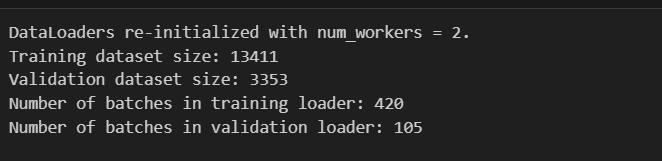

# TereNet
The model shall be known as TereNet, humbly named in honor of  me.

## TereNet architechture
i am using the  3 conv layers and 1 dense one, i tried to use the more advnaced arhcitechture like couple of convolution and in 1 block different dropouts and additional FC layer, but during training it was starting at 3-4%, and collab was disconnected so i ditched the idea.

In [44]:
class TereNet(nn.Module):
    def __init__(self, num_classes):
        super(TereNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(128 * 16 * 16, 512)
        self.bn_fc1 = nn.BatchNorm1d(512)

        self.fc2 = nn.Linear(512, num_classes)

        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))

        x = x.view(x.size(0), -1)

        x = self.dropout(F.relu(self.bn_fc1(self.fc1(x))))
        x = self.fc2(x)
        return x


In [45]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TereNet(num_classes=num_classes).to(device)
print(device)
# Print the model architecture
print("TereNet Model Architecture:")
print(model)

# Print the number of classes
print(f"\nNumber of classes detected: {num_classes}")

cuda
TereNet Model Architecture:
TereNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32768, out_features=512, bias=True)
  (bn_fc1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=512, out_features=42, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

Number of classes detected: 42


In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from collections import Counter
import gc

# ============================================================
# Calculate Class Weights
# ============================================================
print("="*60)
print("Calculating class weights for imbalanced dataset...")
print("="*60)

# Get all labels from training dataset
train_labels = []
for _, label in train_dataset:
    train_labels.append(label)

# Count samples per class
class_counts = Counter(train_labels)
print(f"\nClass distribution:")
for class_idx in sorted(class_counts.keys()):
    print(f"  Class {class_idx}: {class_counts[class_idx]} samples")

# Calculate weights (inverse frequency)
total_samples = len(train_labels)
class_weights = []
for class_idx in range(num_classes):
    count = class_counts.get(class_idx, 1)  # Avoid division by zero
    weight = total_samples / (num_classes * count)
    class_weights.append(weight)

# Convert to tensor and move to device
class_weights_tensor = torch.FloatTensor(class_weights).to(device)

print(f"\nClass weights calculated:")
print(f"  Min weight: {min(class_weights):.4f}")
print(f"  Max weight: {max(class_weights):.4f}")
print(f"  Mean weight: {np.mean(class_weights):.4f}")
print("="*60 + "\n")


Calculating class weights for imbalanced dataset...

Class distribution:
  Class 0: 602 samples
  Class 2: 397 samples
  Class 3: 64 samples
  Class 4: 666 samples
  Class 5: 66 samples
  Class 6: 753 samples
  Class 7: 634 samples
  Class 8: 29 samples
  Class 9: 298 samples
  Class 11: 289 samples
  Class 12: 17 samples
  Class 13: 16 samples
  Class 14: 79 samples
  Class 16: 307 samples
  Class 17: 754 samples
  Class 18: 201 samples
  Class 19: 3 samples
  Class 21: 79 samples
  Class 22: 819 samples
  Class 23: 44 samples
  Class 24: 152 samples
  Class 25: 697 samples
  Class 27: 952 samples
  Class 28: 918 samples
  Class 29: 238 samples
  Class 31: 48 samples
  Class 32: 783 samples
  Class 33: 43 samples
  Class 34: 28 samples
  Class 35: 62 samples
  Class 36: 68 samples
  Class 37: 559 samples
  Class 38: 28 samples
  Class 39: 35 samples
  Class 41: 116 samples

Class weights calculated:
  Min weight: 0.2712
  Max weight: 258.1905
  Mean weight: 47.9196



Tried to use more deep networks more convolution layers and  in each block, also increase size of the block and number of FC layers  but the training started at 4 percent and after half hou it went up as 17, so i ditched the idea(also my notebook session got disconnected),

In [47]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from collections import Counter
import gc



# ============================================================
# Define Loss Function and Optimizer
# ============================================================
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("Using weighted CrossEntropyLoss to handle class imbalance")
print(f"Optimizer: Adam with lr=0.001\n")

# Set number of training epochs
num_epochs = 20

# Initialize lists to store metrics
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

print("Starting training...\n")

# ============================================================
# Training Loop
# ============================================================
for epoch in range(num_epochs):
    print(f"\n{'='*60}")
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"{'='*60}")

    # Training Phase
    model.train()
    running_train_loss = 0.0
    correct_train_predictions = 0
    total_train_samples = 0

    print("Training phase started...")
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train_samples += labels.size(0)
        correct_train_predictions += (predicted == labels).sum().item()

        if (batch_idx + 1) % 20 == 0 or (batch_idx + 1) == len(train_loader):
            current_acc = 100 * correct_train_predictions / total_train_samples
            print(f"  Batch [{batch_idx+1}/{len(train_loader)}] - "
                  f"Loss: {loss.item():.4f}, Acc: {current_acc:.2f}%")

    epoch_train_loss = running_train_loss / total_train_samples
    epoch_train_accuracy = 100 * correct_train_predictions / total_train_samples
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_accuracy)

    print(f"\nTraining complete - Loss: {epoch_train_loss:.4f}, Acc: {epoch_train_accuracy:.2f}%")

    # Clear GPU cache before validation
    if device.type == 'cuda':
        torch.cuda.empty_cache()
    gc.collect()

    # Validation Phase
    print("\nValidation phase started...")
    model.eval()
    running_val_loss = 0.0
    correct_val_predictions = 0
    total_val_samples = 0

    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(val_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)

            predicted_cpu = predicted.cpu()
            labels_cpu = labels.cpu()

            total_val_samples += labels_cpu.size(0)
            correct_val_predictions += (predicted_cpu == labels_cpu).sum().item()

            del inputs, labels, outputs, loss, predicted, predicted_cpu, labels_cpu

            if (batch_idx + 1) % 10 == 0 or (batch_idx + 1) == len(val_loader):
                current_val_acc = 100 * correct_val_predictions / total_val_samples
                print(f"  Val Batch [{batch_idx+1}/{len(val_loader)}] - Acc: {current_val_acc:.2f}%")

                if device.type == 'cuda' and (batch_idx + 1) % 10 == 0:
                    torch.cuda.empty_cache()

    epoch_val_loss = running_val_loss / total_val_samples
    epoch_val_accuracy = 100 * correct_val_predictions / total_val_samples
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_accuracy)

    print(f"\n{'*'*60}")
    print(f'Epoch [{epoch+1}/{num_epochs}] Summary:')
    print(f'  Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_accuracy:.2f}%')
    print(f'  Val Loss:   {epoch_val_loss:.4f} | Val Acc:   {epoch_val_accuracy:.2f}%')
    print(f"{'*'*60}")

    if device.type == 'cuda':
        torch.cuda.empty_cache()
    gc.collect()

print("\n" + "="*60)
print("✓ Training finished!")
print("="*60)
print(f"Final Training Accuracy:   {train_accuracies[-1]:.2f}%")
print(f"Final Validation Accuracy: {val_accuracies[-1]:.2f}%")

Using weighted CrossEntropyLoss to handle class imbalance
Optimizer: Adam with lr=0.001

Starting training...


Epoch 1/20
Training phase started...
  Batch [20/339] - Loss: 3.4426, Acc: 11.41%
  Batch [40/339] - Loss: 3.0014, Acc: 15.94%
  Batch [60/339] - Loss: 3.6328, Acc: 17.50%
  Batch [80/339] - Loss: 9.4393, Acc: 18.52%
  Batch [100/339] - Loss: 2.7584, Acc: 19.38%
  Batch [120/339] - Loss: 3.3380, Acc: 20.83%
  Batch [140/339] - Loss: 2.3419, Acc: 22.39%
  Batch [160/339] - Loss: 2.9528, Acc: 23.44%
  Batch [180/339] - Loss: 2.4412, Acc: 24.57%
  Batch [200/339] - Loss: 2.8667, Acc: 25.52%
  Batch [220/339] - Loss: 3.2987, Acc: 26.51%
  Batch [240/339] - Loss: 3.6185, Acc: 26.82%
  Batch [260/339] - Loss: 2.2289, Acc: 27.51%
  Batch [280/339] - Loss: 2.3351, Acc: 28.11%
  Batch [300/339] - Loss: 2.9306, Acc: 28.72%
  Batch [320/339] - Loss: 2.5701, Acc: 29.31%
  Batch [339/339] - Loss: 4.2753, Acc: 30.10%

Training complete - Loss: 2.8613, Acc: 30.10%

Validation phase started.

lets see what is F1 score in the validation test

In [48]:
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import numpy as np

print("="*60)
print("Calculating F1 Score on Validation Set")
print("="*60)

# Get predictions on validation set
model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

# Convert to numpy arrays
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

# Calculate F1 scores
f1_macro = f1_score(all_labels, all_predictions, average='macro')
f1_micro = f1_score(all_labels, all_predictions, average='micro')
f1_weighted = f1_score(all_labels, all_predictions, average='weighted')

print(f"\nF1 Scores on Validation Set:")
print(f"  Macro F1:    {f1_macro:.4f}")
print(f"  Micro F1:    {f1_micro:.4f}")
print(f"  Weighted F1: {f1_weighted:.4f}")

# Print detailed classification report
print(f"\nDetailed Classification Report:")
print(classification_report(all_labels, all_predictions, digits=4))

Calculating F1 Score on Validation Set

F1 Scores on Validation Set:
  Macro F1:    0.7053
  Micro F1:    0.8204
  Weighted F1: 0.8218

Detailed Classification Report:
              precision    recall  f1-score   support

           0     0.7664    0.8140    0.7895       129
           2     0.6897    0.9804    0.8097       102
           3     0.4211    0.7619    0.5424        21
           4     0.7647    0.7738    0.7692       168
           5     0.7273    0.6154    0.6667        13
           6     0.7979    0.7624    0.7797       202
           7     0.8926    0.8581    0.8750       155
           8     0.8000    0.4444    0.5714         9
           9     0.8194    0.7564    0.7867        78
          11     0.7848    0.8052    0.7949        77
          12     0.8000    0.8000    0.8000         5
          13     1.0000    0.3333    0.5000         6
          14     0.4211    0.8889    0.5714        18
          16     0.9310    0.8804    0.9050        92
          17     0.83

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


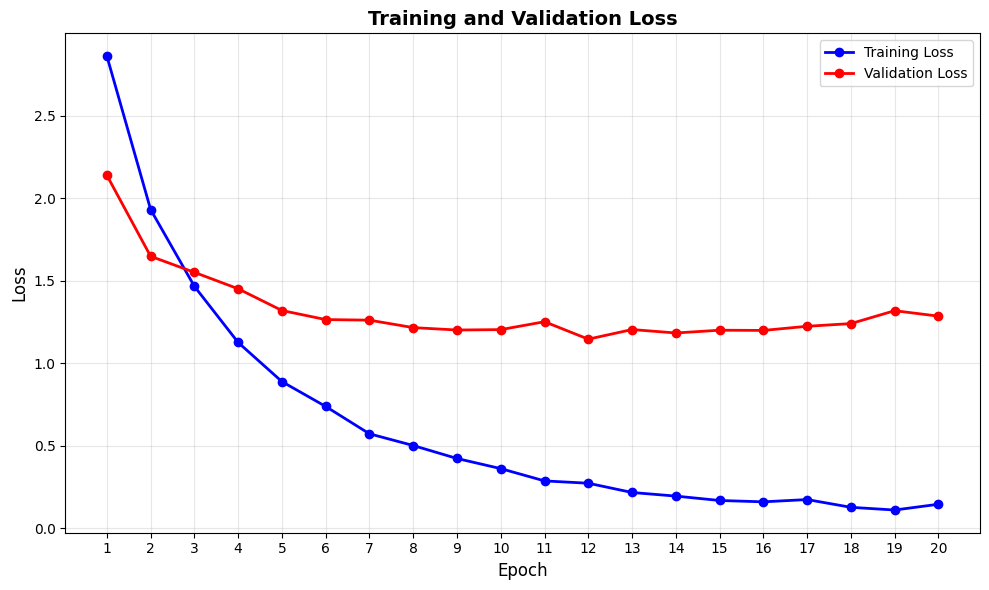


✓ Loss curve saved as 'loss_curve.png'

Loss Summary:
Initial Training Loss:   2.8613
Final Training Loss:     0.1460
Initial Validation Loss: 2.1390
Final Validation Loss:   1.2856
Lowest Training Loss:    0.1110 (Epoch 19)
Lowest Validation Loss:  1.1462 (Epoch 12)


In [51]:
import matplotlib.pyplot as plt

# Create figure with single plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot loss curves
ax.plot(range(1, len(train_losses) + 1), train_losses, 'b-o', label='Training Loss', linewidth=2, markersize=6)
ax.plot(range(1, len(val_losses) + 1), val_losses, 'r-o', label='Validation Loss', linewidth=2, markersize=6)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Loss', fontsize=12)
ax.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xticks(range(1, len(train_losses) + 1))

plt.tight_layout()
plt.savefig('loss_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Loss curve saved as 'loss_curve.png'")

# Print loss statistics only
print(f"\n{'='*60}")
print("Loss Summary:")
print(f"{'='*60}")
print(f"Initial Training Loss:   {train_losses[0]:.4f}")
print(f"Final Training Loss:     {train_losses[-1]:.4f}")
print(f"Initial Validation Loss: {val_losses[0]:.4f}")
print(f"Final Validation Loss:   {val_losses[-1]:.4f}")
print(f"Lowest Training Loss:    {min(train_losses):.4f} (Epoch {train_losses.index(min(train_losses)) + 1})")
print(f"Lowest Validation Loss:  {min(val_losses):.4f} (Epoch {val_losses.index(min(val_losses)) + 1})")

In [ ]:
# Save the model
torch.save(model, 'terenet_model.pth')
print("✓ Model saved as 'terenet_model.pth'")

# Load the model later
model = torch.load('terenet_model.pth',weights_only=False)
model.eval()
(torch.save(model.state_dict(), 'terenet_model1.pth')) # better to use this way

✓ Model saved as 'terenet_model.pth'


TereNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32768, out_features=512, bias=True)
  (bn_fc1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=512, out_features=42, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)